## Using Google's Natural Language AI to obtain sentiment results from our scraped data

#### Contributors: Arsh Singh

In [14]:
# Install required packages
%pip install google-cloud-language

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from google.cloud import language_v1
import csv
import json 
import matplotlib.pyplot as plt

# Replace with your service account key path
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './service-account-key.json'

In [3]:
def analyze_sentiment(text_content):
    client = language_v1.LanguageServiceClient()
    
    document = language_v1.Document(
        content=text_content,
        type_=language_v1.Document.Type.PLAIN_TEXT
    )
    
    sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
    entities = client.analyze_entities(request={'document': document}).entities
    
    sentiment_description = "Positive" if sentiment.score > 0 else "Negative" if sentiment.score < 0 else "Neutral"
    
    return {
        'sentiment_score': sentiment.score,
        'sentiment_magnitude': sentiment.magnitude,
        'sentiment_description': sentiment_description,
        'entities': [(entity.name, entity.type_.name, entity.salience) for entity in entities]
    }


In [17]:
def analyze_real_data(file_path):
    output_data = []
    with open(file_path, mode='r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            review = row['caption']
            if review:
                results = analyze_sentiment(review)
                review_data = {
                    'id_review': row['id_review'],
                    'review': review,
                    'sentiment_score': results['sentiment_score'],
                    'sentiment_magnitude': results['sentiment_magnitude'],
                    'sentiment_description': results['sentiment_description'],
                    'entities': [{'name': entity, 'type': entity_type, 'salience': salience} for entity, entity_type, salience in results['entities']]
                }
                output_data.append(review_data)
    
    with open('real_data_sentiment_analysis_results.json', 'w') as f:
        json.dump(output_data, f, indent=4)

# PATH TO REAL DATA
analyze_real_data('../Scrape/data/newest_gm_reviews.csv')

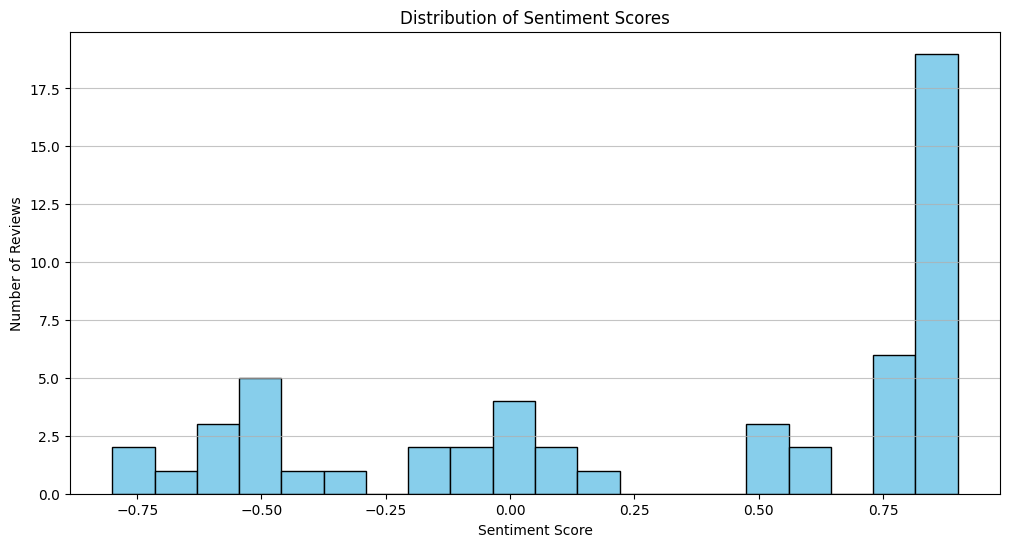

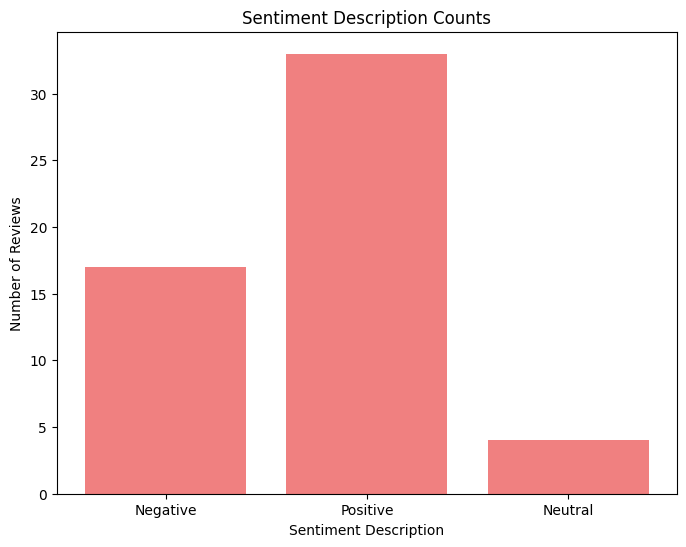

In [4]:
# Load the sentiment analysis results
with open('real_data_sentiment_analysis_results.json', 'r') as f:
    sentiment_data = json.load(f)

sentiment_scores = [review['sentiment_score'] for review in sentiment_data]
sentiment_descriptions = [review['sentiment_description'] for review in sentiment_data]

sentiment_counts = {}
for description in sentiment_descriptions:
    if description in sentiment_counts:
        sentiment_counts[description] += 1
    else:
        sentiment_counts[description] = 1

# Plot sentiment score distribution
plt.figure(figsize=(12, 6))
plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot sentiment description counts
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color='lightcoral')
plt.title('Sentiment Description Counts')
plt.xlabel('Sentiment Description')
plt.ylabel('Number of Reviews')
plt.show()

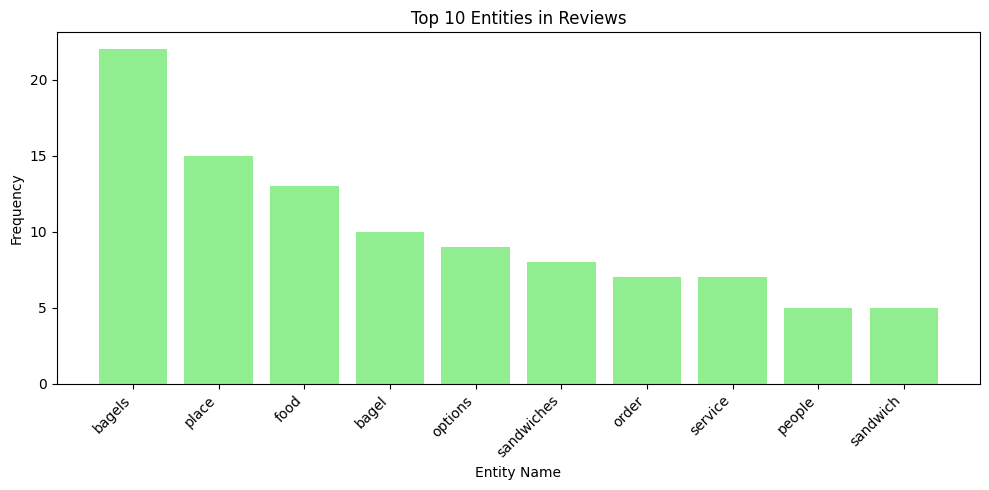

In [19]:
entity_data = [review['entities'] for review in sentiment_data]
flattened_entities = [entity for sublist in entity_data for entity in sublist]

entity_counts = {}
for entity in flattened_entities:
    name = entity['name']
    if name in entity_counts:
        entity_counts[name] += 1
    else:
        entity_counts[name] = 1

sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)

# Plot the top 10 entities
top_entities = sorted_entities[:10]
entity_names, entity_frequencies = zip(*top_entities)

plt.figure(figsize=(10, 5))
plt.bar(entity_names, entity_frequencies, color='lightgreen')
plt.title('Top 10 Entities in Reviews')
plt.xlabel('Entity Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

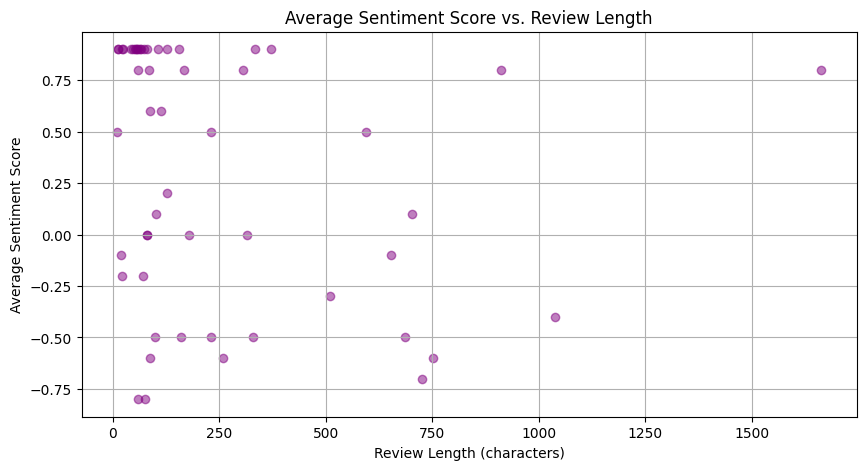

In [5]:
# Plot the average sentiment score per review length
review_lengths = [len(review['review']) for review in sentiment_data]
average_sentiment_scores = [review['sentiment_score'] for review in sentiment_data]

plt.figure(figsize=(10, 5))
plt.scatter(review_lengths, average_sentiment_scores, color='purple', alpha=0.5)
plt.title('Average Sentiment Score vs. Review Length')
plt.xlabel('Review Length (characters)')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()


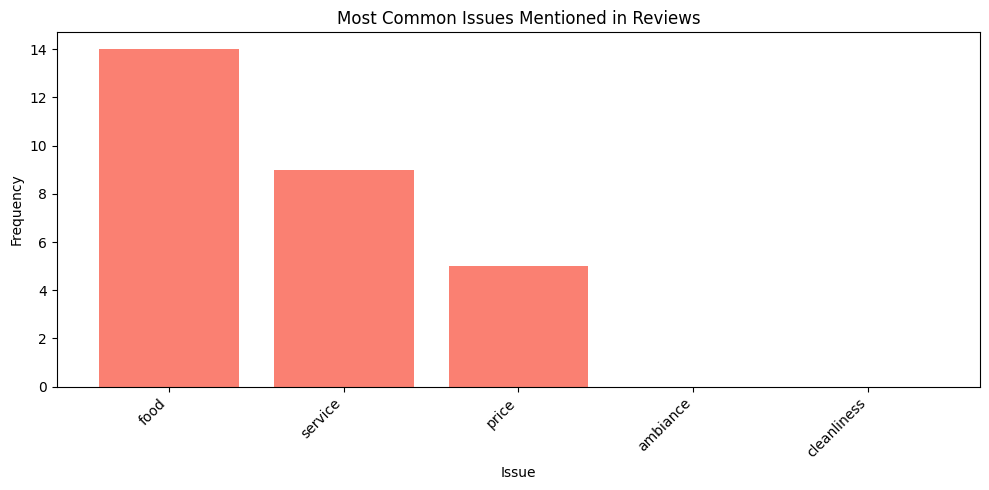

In [6]:
# Plot the most common issues mentioned in reviews
issue_keywords = ['service', 'food', 'price', 'ambiance', 'cleanliness']
issue_counts = {keyword: 0 for keyword in issue_keywords}

for review in sentiment_data:
    review_text = review['review'].lower()
    for keyword in issue_keywords:
        if keyword in review_text:
            issue_counts[keyword] += 1

sorted_issues = sorted(issue_counts.items(), key=lambda x: x[1], reverse=True)
issue_names, issue_frequencies = zip(*sorted_issues)

plt.figure(figsize=(10, 5))
plt.bar(issue_names, issue_frequencies, color='salmon')
plt.title('Most Common Issues Mentioned in Reviews')
plt.xlabel('Issue')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()